<a href="https://colab.research.google.com/github/jchen8000/GenerativeAI/blob/main/4_Pre-Training_Fine-Tuning/LoRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4.13	Low-Rank Adaptation (LoRA)

This code is tested and working on Google Colab GPU T4 with below packages

*   pip==24.0
*   torch==2.1.0+cu121
*   torchvision==0.17.1+cu121
*   torchaudio==2.2.1+cu121
*   datasets==2.18.0
*   sentencepiece==0.1.99
*   transformers==4.38.2
*   rouge_score==0.1.2


In [1]:
!pip install --upgrade pip
!pip install torch torchvision torchaudio --quiet
!pip install datasets --quiet
!pip install transformers --quiet
!pip install peft --quiet
!pip install rouge_score --quiet
!pip install sentencepiece --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 1.8 MB

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
from datasets import load_dataset, Dataset, load_metric
from transformers import T5Tokenizer
from transformers import T5ForConditionalGeneration
from transformers import TrainingArguments
from transformers import Trainer
from transformers import GenerationConfig
from rouge_score import rouge_scorer
from peft import LoraConfig, get_peft_model, TaskType
import warnings

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
warnings.filterwarnings('ignore')

## Load FLAN-T5 Base model

In [3]:
model_name = 'google/flan-t5-base'
lora_model_name = 'outputs/flan-t5-base_lora'
def load_model(model_name):
    tokenizer = T5Tokenizer.from_pretrained(model_name)
    model = T5ForConditionalGeneration.from_pretrained(model_name, torch_dtype=torch.bfloat16)
    return tokenizer, model

tokenizer, model = load_model(model_name)
total_parameter = sum(p.numel() for p in model.parameters())
print(f"Parameters of the model: {total_parameter:,}")

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Parameters of the model: 247,577,856


## Load TweetSum Dataset

https://github.com/sarahaman/CIS6930_TweetSum_Summarization

Make sure the three files in the datasets folder:

*  tweetsum_train.csv
*  tweetsum_valid.csv
*  tweetsum_test.csv

In [4]:
tweetsum = load_dataset('csv', data_files={'train': 'datasets/tweetsum_train.csv',
                                          'validation': 'datasets/tweetsum_valid.csv',
                                          'test': 'datasets/tweetsum_test.csv'})
print(tweetsum)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['inputs', 'summaries'],
        num_rows: 869
    })
    validation: Dataset({
        features: ['inputs', 'summaries'],
        num_rows: 108
    })
    test: Dataset({
        features: ['inputs', 'summaries'],
        num_rows: 110
    })
})


## Tokenize the dataset

In [5]:
def tokenize_function(example):
  prompt = ["Summarize: " + s for s in example['inputs']]
  example['input_ids'] = tokenizer(prompt, padding="max_length", truncation=True, return_tensors="pt").input_ids
  example['labels'] = tokenizer(example['summaries'], padding="max_length", truncation=True, return_tensors="pt").input_ids
  return example

Take a subset of the original dataset, in order to run the fine-tuning on the limited resources (single GPU, etc.)

In [6]:
tokenized_datasets = tweetsum.map(tokenize_function, batched=True)
print(tokenized_datasets)

Map:   0%|          | 0/869 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

Map:   0%|          | 0/110 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['inputs', 'summaries', 'input_ids', 'labels'],
        num_rows: 869
    })
    validation: Dataset({
        features: ['inputs', 'summaries', 'input_ids', 'labels'],
        num_rows: 108
    })
    test: Dataset({
        features: ['inputs', 'summaries', 'input_ids', 'labels'],
        num_rows: 110
    })
})


## Preliminary evaluation by human assessment

In [7]:
def generate_output(tokenizer, model, input_text, max_length=200):
    # Tokenize the input text and generate the model's output
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids
    outputs = model.generate(
        input_ids=input_ids,
        generation_config=GenerationConfig(max_new_tokens=200, num_beams=1) )

    # Decode the generated tokens to a string
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response


Produce the output on the randomly selected data samples:

In [8]:
for item in random.choices(list(tokenized_datasets['test']), k = 5):
    prompt = "Summarize: " + item['inputs']
    output = generate_output(tokenizer, model, prompt)
    print("Prompt:", prompt)
    print("Target:", item['summaries'])
    print("Predict:", output)
    print()

Prompt: Summarize:  <LINK> <BR> We want to make sure youre taken care of, Tony. Well be meeting you back in DM ASAP to continue helping <LINK> DanKing <BR> TMobileHelp You didnt help yesterday and you wont help today. But, now tour ceo knows how terrible you are at your jobs. Lets see if he replies to me. <BR> TMobileHelp Cause heres a news flash I DONT WORK FOR YOU. So dont send me a link to correct YOUR clerical error. Pick upma phone snd call me amp fix <BR> TMobileHelp And, saying you dont have access to a phone is LAUGH OUT LOUD FUNNY, since youre a phone company <BR> TMobileHelp Youll see in notes if u bother the unlock rq went in to Apple yesterday you have 24 hrs till im gone <BR> We truly want to help. I just sent a DM your way and can absolutely give you a call. StephanieGarza <BR> TMobileHelp Yeah. Was a real crack up that you say you font know my cell <BR> TMobileHelp Hey John could our bill be 10 less each month by closing this USELESS dept? Lets look into it. <BR> I just 

## Fine-tuning with LoRA

In [9]:
rank = 16
lora_config = LoraConfig(
    r=rank,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM  #FLAN-T5
)

In [10]:
lora_model = get_peft_model(model, lora_config)
total_parameter = sum(p.numel() for p in lora_model.parameters())
lora_parameter = sum(p.numel() for p in lora_model.parameters() if p.requires_grad)
print(f"Total Parameters: {total_parameter:,}")
print(f"LoRA Parameters: {lora_parameter:,}; Percentage: {lora_parameter/total_parameter}")

Total Parameters: 249,347,328
LoRA Parameters: 1,769,472; Percentage: 0.007096414524241463


In [11]:
# print(lora_model)

In [12]:
max_steps = 300

lora_training_args = TrainingArguments(
    learning_rate=1e-3,
    auto_find_batch_size=True,
    logging_steps=1,
    max_steps=max_steps,
    output_dir = 'outputs' )

lora_triner = Trainer(
    model=lora_model,
    args=lora_training_args,
    train_dataset=tokenized_datasets['train'],
    )

lora_triner.train()

Step,Training Loss
1,43.000000
2,42.250000
3,37.750000
4,35.500000
5,33.250000
6,31.375000
7,28.875000
8,26.875000
9,25.000000
10,23.375000


TrainOutput(global_step=300, training_loss=2.100166015625, metrics={'train_runtime': 684.2204, 'train_samples_per_second': 3.508, 'train_steps_per_second': 0.438, 'total_flos': 1652322450014208.0, 'train_loss': 2.100166015625, 'epoch': 2.75})

In [13]:
lora_triner.save_model(lora_model_name)

## Visualize the fine-tuning

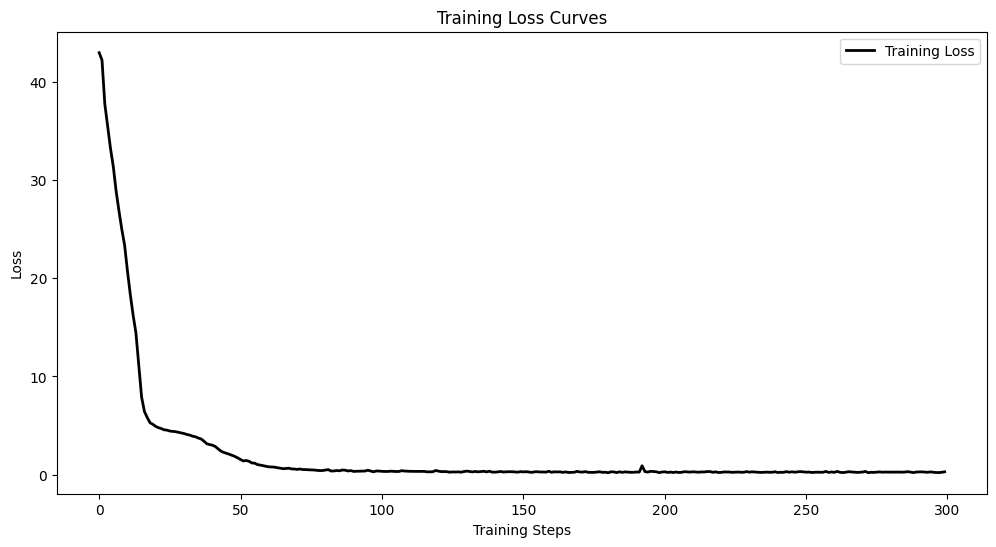

In [14]:
log_history = lora_triner.state.log_history
df = pd.DataFrame(log_history)

if 'loss' in df.columns:
    df_filtered = df.dropna(subset=['loss'], how='all')
    df_filtered.reset_index(drop=True, inplace=True)

    plt.figure(figsize=(12, 6))
    plt.plot(df_filtered['loss'], lw=2, c='k', label='Training Loss')

    plt.title('Training Loss Curves')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig("outputs/fine-tuning.svg", format="svg", dpi=150, transparent=True, bbox_inches='tight')
    plt.show()

## Evaluation on the fine-tuned model

Load the saved fine-tuned model:

In [15]:
from peft import PeftModel, PeftConfig
tokenizer, base_model = load_model(model_name)
peft_model = PeftModel.from_pretrained(base_model,
                                       lora_model_name,
                                       torch_dtype=torch.bfloat16,
                                       is_trainnable=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


ROUGE Scores:

In [16]:
scorer = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=True)
for item in random.choices(list(tokenized_datasets['test']), k = 5):
    prompt = "Summarize: " + item['inputs']
    output = generate_output(tokenizer, peft_model, prompt)
    scores = scorer.score(item['summaries'], output)
    print("Target:", item['summaries'])
    print("Predict:", output)
    print(scores)
    print()

Token indices sequence length is longer than the specified maximum sequence length for this model (744 > 512). Running this sequence through the model will result in indexing errors


Target: Customer is waiting over 3 weeks for compensation that was promised . Agent informed that he will get back to him with further  information.
Predict: Customer is complaining about the delay in payment of compensation. Agent is asking for an additional gesture of goodwill.
{'rouge1': Score(precision=0.2631578947368421, recall=0.21739130434782608, fmeasure=0.23809523809523808)}

Target: Customer is complaining about the new updates IOS11 and can't even use some apps on phone. Agent asks to send a DM and work from there URL.
Predict: Advice: the new update ios11 sucks. I cant even use some apps on my phone.
{'rouge1': Score(precision=0.6666666666666666, recall=0.35714285714285715, fmeasure=0.46511627906976744)}

Target: Customer is complaining about issues with claiming train delay compensation. Agent states to claim the compensation for the entire journey.
Predict: Customer is complaining about the delay and the delay from Southern.
{'rouge1': Score(precision=0.6363636363636364, 